# San Francisco Crimes

## importing the libraries

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

## Loading the dataset to a dataframe

In [128]:
df = pd.read_csv('train.csv')

## Exploring the dataframe

In [130]:
df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


In [134]:
df = df.sample(n=10000, random_state=42)

## Turning the dates to hours, days, months and years

In [136]:
df['Dates'] = pd.to_datetime(df['Dates'])

In [138]:
df['Hour'] = df['Dates'].dt.hour
df['Day'] = df['Dates'].dt.day
df['Month'] = df['Dates'].dt.month
df['Year'] = df['Dates'].dt.year

In [140]:
df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Hour,Day,Month,Year
349598,2010-07-04 23:00:00,LARCENY/THEFT,ATTEMPTED GRAND THEFT FROM PERSON,Sunday,TENDERLOIN,NONE,100 Block of POWELL ST,-122.407878,37.785968,23,4,7,2010
766313,2004-06-26 22:43:00,ASSAULT,BATTERY OF A POLICE OFFICER,Saturday,PARK,"ARREST, BOOKED",2400 Block of GEARY BL,-122.443597,37.782644,22,26,6,2004
169887,2013-02-09 21:26:00,OTHER OFFENSES,VIOLATION OF MUNICIPAL CODE,Saturday,SOUTHERN,"ARREST, CITED",HOWARD ST / 3RD ST,-122.400474,37.785029,21,9,2,2013
594704,2006-12-03 22:30:00,WEAPON LAWS,POSS OF PROHIBITED WEAPON,Sunday,NORTHERN,"ARREST, CITED",VANNESS AV / HAYES ST,-122.419698,37.777301,22,3,12,2006
47900,2014-09-21 08:45:00,LARCENY/THEFT,PETTY THEFT FROM UNLOCKED AUTO,Sunday,PARK,NONE,BEULAH ST / SHRADER ST,-122.451488,37.767516,8,21,9,2014


## Selecting the features to work with

In [142]:
features = ['X', 'Y', 'Category', 'Hour', 'Day', 'Month', 'Year']

In [144]:
df_features = df[features]

In [146]:
label_encoder = LabelEncoder()

## Label encoding and non numeric features

In [147]:
for column in df_features.select_dtypes(include=['object']).columns:
    df_features[column] = label_encoder.fit_transform(df_features[column])

/var/folders/7j/fk7__3j54fv0wqh73h0dtv700000gn/T/ipykernel_1806/3544582189.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features[column] = label_encoder.fit_transform(df_features[column])


In [148]:
df_features.head()

,X,Y,Category,Hour,Day,Month,Year
349598,-122.407878,37.785968,16,23,4,7,2010
766313,-122.443597,37.782644,1,22,26,6,2004
169887,-122.400474,37.785029,21,21,9,2,2013
594704,-122.419698,37.777301,35,22,3,12,2006
47900,-122.451488,37.767516,16,8,21,9,2014


In [149]:
scaler = StandardScaler()

## Standard scaling all features

In [150]:
df_features_scaled = pd.DataFrame(
    scaler.fit_transform(df_features),
    columns=df_features.columns,
    index=df_features.index
)

In [151]:
df_features_scaled.head()

,X,Y,Category,Hour,Day,Month,Year
349598,0.589337,0.790005,-0.281446,1.470466,-1.330245,0.158224,0.357084
766313,-0.814524,0.652168,-1.810709,1.318809,1.186061,-0.133004,-1.288337
169887,0.880341,0.751075,0.228309,1.167152,-0.758357,-1.297917,1.179794
594704,0.124782,0.430659,1.655621,1.318809,-1.444623,1.614365,-0.739864
47900,-1.124644,0.024978,-0.281446,-0.804388,0.614173,0.740681,1.454031


## Applying pca to reduce the dimentionality

In [152]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(df_features_scaled)

## Applying k-medoid clustering

In [153]:
kmedoids = KMedoids(n_clusters=5, random_state=42)
clusters = kmedoids.fit_predict(reduced_features)

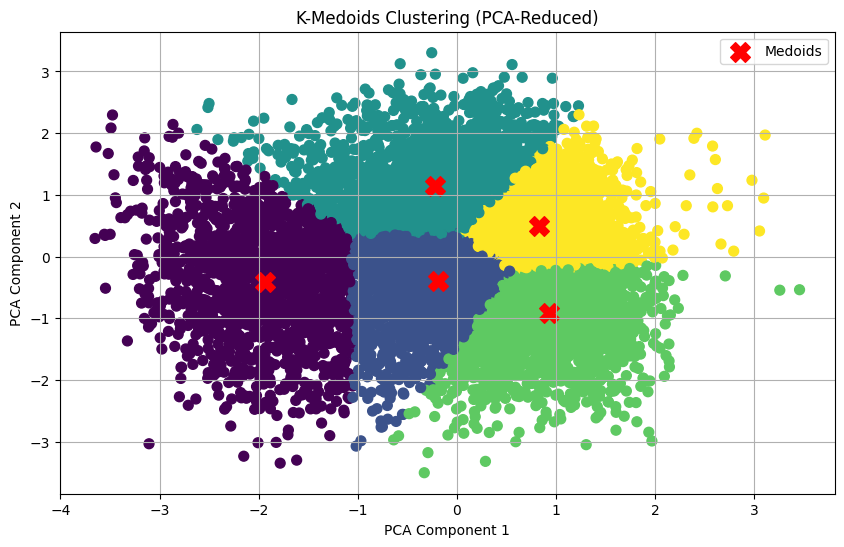

In [154]:
plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', s=50)
medoid_points = pca.transform(df_features_scaled.iloc[kmedoids.medoid_indices_])
plt.scatter(medoid_points[:, 0], medoid_points[:, 1], color='red', marker='X', s=200, label='Medoids')

plt.title("K-Medoids Clustering (PCA-Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()


## Applying Hieurarical clustering

In [178]:
Z = linkage(reduced_features, method='ward')

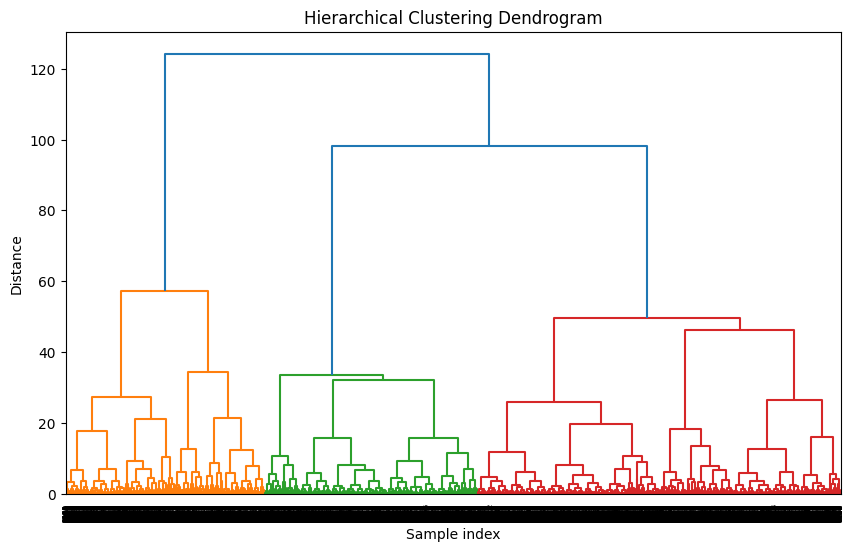

In [181]:
plt.figure(figsize=(10, 6))
dendrogram(Z)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()